# Capstone 2: *National Transit Database*
## *Preprocessing and Training*
***

## 3.1 Table of Contents<a id='3.1_Contents'></a>
* [3 Preprocessing and Training](#3_Preprocessing_and_Training)
  * [3.1 Table of Contents](#3.1_Contents)
  * [3.2 Introduction](#3.2_Introduction)
  * [3.3 Importing the Dependencies](#3.3_Importing_the_Dependencies)
  * [3.4 Importing the Data](#3.4_Importing_the_Data)
  * [3.5 Defining Safety](#3.5_Defining_Safety)
      * [3.5.1 'Total Events' Column](#3.5.1_Total_Events_Column)
      * [3.5.2 Drop Columns Captured by 'Total Events'](#3.5.2_Drop_Columns_Captured_by_Total_Events)
      * [3.5.3 Change Dataframes to Annual](#3.5.3_Change_Dataframes_to_Annual)
      * [3.5.4 Add 'Cumulative Safety per 100K VRM' Column](#3.5.4_Add_Cumulative_Safety_per_100K_VRM_Column)
      * [3.5.5 Drop Columns Accounted for in 'Cumulative Safety per 100K VRM'](#3.5.5_Add_Cumulative_Safety_per_100K_VRM_Column)

  * [3.6 Dropping Unneeded Columns](#3.6_Dropping_Unneeded_Columns)
  * [3.7 Encoding the Categorical Features](#3.7_Encoding_the_Categorical_Features)
  * [3.8 Exploring the Data](#3.8_Exploring_the_Data)
  * [3.9 Model Selection](#3.9_Model_Selection)
      * [3.9.1 Train/Test Split](#3.9.1_Train_Test_Split)
      * [3.9.2 Linear Regression](#3.9.2_Linear_Regression)
      * [3.9.3 Random Forest](#3.9.3_Random_Forest)
      * [3.9.4 KNN](#3.9.4_KNN)
      * [3.9.5 Comparing the Models' Performance](#3.9.5_Comparing_the_Models_Performance)
  * [3.10 Save the Data](#3.10_Save_the_Data)
  * [3.11 Summary](#3.11_Summary)

## 3.2 Introduction
<a id='3.2_Introduction'></a>

In the preceeding notebook, I refined the dataframes and began to explore the relationships between the variables.  In this notebook, I will further refine the data so only clear, valuable, numeric columns are remaining for the independent variables and so there is a single, clear, and distinct value for the dependent variable.  I will then split the data in train/test sets and evaluate the performance of several models to determine which is best suited for this project.

## 3.3 Importing the Dependencies
<a id='3.3_Importing_the_Dependencies'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from itertools import groupby
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_percentage_error

pd.set_option('display.max_rows', 70)

## 3.4 Importing the Data
<a id='3.4_Importing_the_Data'></a>

In [2]:
National_data = pd.read_csv("reduced_data.csv")
Nashville_data = pd.read_csv("Nashville_data.csv")

In [3]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   5 DIgit NTD ID                         129752 non-null  int64  
 1   Agency                                 129752 non-null  object 
 2   Organization Type                      129752 non-null  object 
 3   Mode                                   129752 non-null  object 
 4   Type of Service                        129752 non-null  object 
 5   Rail (Y/N)                             129752 non-null  bool   
 6   Primary UZA Code                       129752 non-null  float64
 7   Primary UZA Name                       129752 non-null  object 
 8   Primary UZA Sq Miles                   129752 non-null  float64
 9   Primary UZA Population                 129752 non-null  float64
 10  Service Area Sq Miles                  129752 non-null  

In [4]:
Nashville_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   5 DIgit NTD ID                         750 non-null    int64  
 1   Agency                                 750 non-null    object 
 2   Organization Type                      750 non-null    object 
 3   Mode                                   750 non-null    object 
 4   Type of Service                        750 non-null    object 
 5   Rail (Y/N)                             750 non-null    bool   
 6   Primary UZA Code                       750 non-null    float64
 7   Primary UZA Name                       750 non-null    object 
 8   Primary UZA Sq Miles                   750 non-null    float64
 9   Primary UZA Population                 750 non-null    float64
 10  Service Area Sq Miles                  750 non-null    float64
 11  Servic

## 3.5 Defining Safety
<a id='3.5_Defining_Safety'></a>

The FTA requires covered public transportation providers to establish Safety Performance Measures (SPMs) and use them to set annual Safety Perform Targets (SPTs) based.  These targets must depend only on data submittable to the NTD. Since my goal is to assit Nashville in its decision-making, I will use the SPMs of it's largest NTD reporter to guide my definition of safety.  The SPMs and SPTs for the Metropolitan Transit Authority (MTA) dba WeGo Public Transit can be found on page 8 of this document: [MTA Safety Performance Measures](https://www.wegotransit.com/file.aspx?DocumentId=102).  MTA's chosen SPMs match the example given by the FTA in their Safety Performance Targets Guide which can be found here: [FTA SPT Guide](https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-06/SPTs-Guide-v2-20210629.pdf).

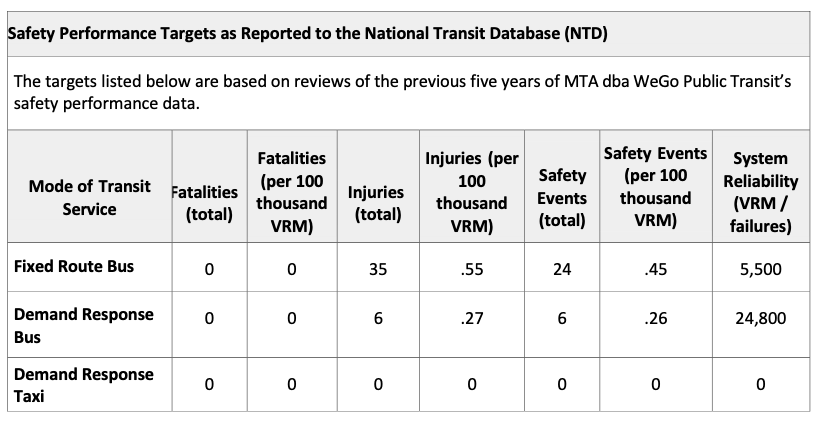

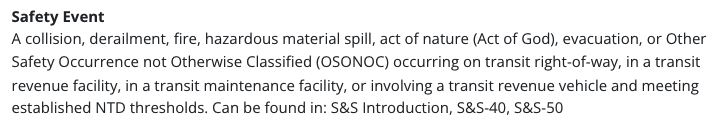

### 3.5.1 'Total Events' Column
<a id='3.5.1_Total_Events_Column'></a>
The NTD database does not have a column called 'Total Safety Events' so I will verify that the 'Toal Events' column is a total of all the events listed in the definition above from given in the [FTA Glossary](https://www.transit.dot.gov/ntd/national-transit-database-ntd-glossary).

In [5]:
#Check to see if 'Total Events" captures all data in columns 'Total Collisions', 'Total Derailments', 'Total Fires',
#'Total Security Events', and 'Total Events Not Otherwise Classified'

National_events = National_data.iloc[:, 18:24]
Nashville_events = Nashville_data.iloc[:, 18:24]
count5 = 0
count6 = 0

for i in National_events.index:
    if sum(National_events.iloc[i,[5]]) != sum(National_events.iloc[i,0:5]):
        count5 += 1
        list5.append(i)

for i in Nashville_events.index:
    if sum(Nashville_events.iloc[i,[5]]) != sum(Nashville_events.iloc[i,0:5]):
        count5 += 1
        list5.append(i)        

print('There are ',count5, "rows where 'Total Events' does not match the sum of the other National columns")
print('There are ',count6, "rows where 'Total Events' does not match the sum of the other Nashville columns")

There are  0 rows where 'Total Events' does not match the sum of the other National columns
There are  0 rows where 'Total Events' does not match the sum of the other Nashville columns


Since the 'Total Events' column is confirmed to be the total of the other columns, I can drop the other columns from both the National and Nashville dataframes.

### 3.5.2 Drop Columns Captured by 'Total Events'
<a id='3.5.2_Drop_Columns_Captured_by_Total_Events'></a>

In [6]:
National_data.shape

(129752, 26)

In [7]:
Nashville_data.shape

(750, 26)

In [8]:
National_data = National_data.drop(National_data.iloc[:, 18:23], axis=1)
Nashville_data = Nashville_data.drop(Nashville_data.iloc[:, 18:23], axis=1)


In [9]:
National_data.shape

(129752, 21)

In [10]:
Nashville_data.shape

(750, 21)

### 3.5.3 Change Dataframes to Annual
<a id='3.5.3_Change_Dataframes_to_Annual'></a>
Since goals reported to the FTA are in annual form, I will change the rows of the dataframes to match.  This will also help with the predictive ability of the models since agencies were permitted to report monthly VRMs as the annual expected number divided by twelve.

In [11]:
National_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129752 entries, 0 to 129751
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   5 DIgit NTD ID           129752 non-null  int64  
 1   Agency                   129752 non-null  object 
 2   Organization Type        129752 non-null  object 
 3   Mode                     129752 non-null  object 
 4   Type of Service          129752 non-null  object 
 5   Rail (Y/N)               129752 non-null  bool   
 6   Primary UZA Code         129752 non-null  float64
 7   Primary UZA Name         129752 non-null  object 
 8   Primary UZA Sq Miles     129752 non-null  float64
 9   Primary UZA Population   129752 non-null  float64
 10  Service Area Sq Miles    129752 non-null  float64
 11  Service Area Population  129752 non-null  float64
 12  Year                     129752 non-null  int64  
 13  Month                    129752 non-null  int64  
 14  Vehi

In [12]:
# Creating the annual columns

National_annual = National_data.copy()
National_annual[[ 'Annual VRM', 'Annual Ridership','Total Events Annual by Mode','Total Fatalities Annual by Mode','Total Injuries Annual by Mode']] = (National_annual.groupby(['5 DIgit NTD ID','Agency','Primary UZA Name','Mode','Year'])[['Vehicle Revenue Miles', 'Ridership', 'Total Events','Total Fatalities', 'Total Injuries']].transform('sum'))

Nashville_annual = Nashville_data.copy()
Nashville_annual[[ 'Annual VRM', 'Annual Ridership','Total Events Annual by Mode','Total Fatalities Annual by Mode','Total Injuries Annual by Mode']] = (Nashville_annual.groupby(['5 DIgit NTD ID','Agency','Primary UZA Name','Mode','Year'])[['Vehicle Revenue Miles', 'Ridership', 'Total Events','Total Fatalities', 'Total Injuries']].transform('sum'))


In [13]:
# Dropping the monthly columns

National_annual = National_annual.drop(National_annual.iloc[:, np.r_[15, 17:21]], axis=1)
Nashville_annual = Nashville_annual.drop(Nashville_annual.iloc[:, np.r_[15, 17:21]], axis=1)


In [14]:
#Condensing the dataframes by dropping duplicate rows (so I have one per annual value instead of up to 12)

National_annual = National_annual.drop_duplicates()
Nashville_annual = Nashville_annual.drop_duplicates()

In [15]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129728 entries, 0 to 129751
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   5 DIgit NTD ID                   129728 non-null  int64  
 1   Agency                           129728 non-null  object 
 2   Organization Type                129728 non-null  object 
 3   Mode                             129728 non-null  object 
 4   Type of Service                  129728 non-null  object 
 5   Rail (Y/N)                       129728 non-null  bool   
 6   Primary UZA Code                 129728 non-null  float64
 7   Primary UZA Name                 129728 non-null  object 
 8   Primary UZA Sq Miles             129728 non-null  float64
 9   Primary UZA Population           129728 non-null  float64
 10  Service Area Sq Miles            129728 non-null  float64
 11  Service Area Population          129728 non-null  float64
 12  Ye

In [16]:
# Renaming columns in annual dataframes to match original monthly dataframes for consistency

#National_data = National_annual.copy()
National_annual = National_annual.rename(columns={
    "Annual VRM": "Vehicle Revenue Miles", 
    "Annual Ridership": "Ridership",
    "Total Events Annual by Mode": "Total Events",
    "Total Fatalities Annual by Mode": "Total Fatalities",
    "Total Injuries Annual by Mode": "Total Injuries"})

#Nashville_data = Nashville_annual.copy()
Nashville_annual = Nashville_annual.rename(columns={
    "Annual VRM": "Vehicle Revenue Miles", 
    "Annual Ridership": "Ridership",
    "Total Events Annual by Mode": "Total Events",
    "Total Fatalities Annual by Mode": "Total Fatalities",
    "Total Injuries Annual by Mode": "Total Injuries"});

In [17]:
cols = list(National_annual.columns.values)
cols

['5 DIgit NTD ID',
 'Agency',
 'Organization Type',
 'Mode',
 'Type of Service',
 'Rail (Y/N)',
 'Primary UZA Code',
 'Primary UZA Name',
 'Primary UZA Sq Miles',
 'Primary UZA Population',
 'Service Area Sq Miles',
 'Service Area Population',
 'Year',
 'Month',
 'Vehicles',
 'Vehicle Revenue Hours',
 'Vehicle Revenue Miles',
 'Ridership',
 'Total Events',
 'Total Fatalities',
 'Total Injuries']

In [18]:
# Reordering columns in annual dataframes to match original monthly dataframes for consistency

National_annual = National_annual[['5 DIgit NTD ID',
 'Agency',
 'Organization Type',
 'Mode',
 'Type of Service',
 'Rail (Y/N)',
 'Primary UZA Code',
 'Primary UZA Name',
 'Primary UZA Sq Miles',
 'Primary UZA Population',
 'Service Area Sq Miles',
 'Service Area Population',
 'Year',
 'Month',
 'Vehicles',
 'Vehicle Revenue Miles',
 'Vehicle Revenue Hours',
 'Ridership',
 'Total Events',
 'Total Fatalities',
 'Total Injuries']]

Nashville_annual = Nashville_annual[['5 DIgit NTD ID',
 'Agency',
 'Organization Type',
 'Mode',
 'Type of Service',
 'Rail (Y/N)',
 'Primary UZA Code',
 'Primary UZA Name',
 'Primary UZA Sq Miles',
 'Primary UZA Population',
 'Service Area Sq Miles',
 'Service Area Population',
 'Year',
 'Month',
 'Vehicles',
 'Vehicle Revenue Miles',
 'Vehicle Revenue Hours',
 'Ridership',
 'Total Events',
 'Total Fatalities',
 'Total Injuries']]

In [19]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129728 entries, 0 to 129751
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   5 DIgit NTD ID           129728 non-null  int64  
 1   Agency                   129728 non-null  object 
 2   Organization Type        129728 non-null  object 
 3   Mode                     129728 non-null  object 
 4   Type of Service          129728 non-null  object 
 5   Rail (Y/N)               129728 non-null  bool   
 6   Primary UZA Code         129728 non-null  float64
 7   Primary UZA Name         129728 non-null  object 
 8   Primary UZA Sq Miles     129728 non-null  float64
 9   Primary UZA Population   129728 non-null  float64
 10  Service Area Sq Miles    129728 non-null  float64
 11  Service Area Population  129728 non-null  float64
 12  Year                     129728 non-null  int64  
 13  Month                    129728 non-null  int64  
 14  Vehi

### 3.5.4 Add 'Cumulative Safety per 100K VRM' Column
<a id='3.5.4_Add_Cumulative_Safety_per_100K_VRM_Column'></a>
In order to have a single column for y, I will combine the three categories of SPTs (fatalities, injuries, and events) into one and present it as a value per 100,000 VRM.  

In [20]:
National_Cumulative_Safety = (National_annual['Total Fatalities'] + National_annual['Total Injuries'] + National_annual['Total Events'])
Nashville_Cumulative_Safety = (Nashville_annual['Total Fatalities'] + Nashville_annual['Total Injuries'] + Nashville_annual['Total Events'])

National_annual['Cumulative Safety per 100K VRM'] = (National_Cumulative_Safety/National_annual['Vehicle Revenue Miles'])*100000
Nashville_annual['Cumulative Safety per 100K VRM'] = (Nashville_Cumulative_Safety/Nashville_annual['Vehicle Revenue Miles'])*100000


In [21]:
National_annual['Cumulative Safety per 100K VRM'].isna().sum()

254

In [22]:
Nashville_annual['Cumulative Safety per 100K VRM'].isna().sum()


0

In rows where there were no fatalities, injuries, or events, I end up with Nans because I have divided by zero.  I will replace the Nans with zeros since that is the logical value.

In [23]:
National_annual['Cumulative Safety per 100K VRM'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
National_annual['Cumulative Safety per 100K VRM'].isna().sum()


0

In [24]:
National_annual['Cumulative Safety per 100K VRM'].isna().sum()

0

In [25]:
National_annual.shape

(129728, 22)

### 3.5.5 Drop Columns Accounted for in 'Cumulative Safety per 100K VRM'
<a id='3.5.5_Add_Cumulative_Safety_per_100K_VRM_Column'></a>
I can now drop the 'Total Revenue Miles', 'Total Fatalities', 'Total Injuries', and 'Total Events' columns since they are accounted for in my new 'Cumulative Safety per 100K VRM' column.

In [26]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129728 entries, 0 to 129751
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   5 DIgit NTD ID                  129728 non-null  int64  
 1   Agency                          129728 non-null  object 
 2   Organization Type               129728 non-null  object 
 3   Mode                            129728 non-null  object 
 4   Type of Service                 129728 non-null  object 
 5   Rail (Y/N)                      129728 non-null  bool   
 6   Primary UZA Code                129728 non-null  float64
 7   Primary UZA Name                129728 non-null  object 
 8   Primary UZA Sq Miles            129728 non-null  float64
 9   Primary UZA Population          129728 non-null  float64
 10  Service Area Sq Miles           129728 non-null  float64
 11  Service Area Population         129728 non-null  float64
 12  Year            

In [27]:
National_annual = National_annual.drop(National_annual.iloc[:, np.r_[15, 18, 19, 20]], axis=1)
Nashville_annual = Nashville_annual.drop(Nashville_annual.iloc[:, np.r_[15, 18, 19, 20]], axis=1)

In [28]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129728 entries, 0 to 129751
Data columns (total 18 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   5 DIgit NTD ID                  129728 non-null  int64  
 1   Agency                          129728 non-null  object 
 2   Organization Type               129728 non-null  object 
 3   Mode                            129728 non-null  object 
 4   Type of Service                 129728 non-null  object 
 5   Rail (Y/N)                      129728 non-null  bool   
 6   Primary UZA Code                129728 non-null  float64
 7   Primary UZA Name                129728 non-null  object 
 8   Primary UZA Sq Miles            129728 non-null  float64
 9   Primary UZA Population          129728 non-null  float64
 10  Service Area Sq Miles           129728 non-null  float64
 11  Service Area Population         129728 non-null  float64
 12  Year            

## 3.6 Dropping Unneeded Columns
<a id='3.6_Dropping_Unneeded_Columns'></a>

'Primary UZA Code' and 'Primary UZA Population' are both ordinal representations of the ranking of population size.  However, 'Primary UZA Code' has the one value (602) which is out of place.  So, 'Primary UZA Code' will be removed.

The columns 'Vehicles' and 'Vehicle Revenue Hours' will be dropped because they are too closely related to 'Vehicle Revenue Miles'.  'Month' and 'Year' will be dropped since I am not preforming time series analysis. 

I will also remove the identifier columns, '5 DIgit NTD ID', 'Agency', and 'Primary UZA Name' so that all references to location will be omitted.

In [29]:
National_annual = National_annual.drop(['Primary UZA Code', 'Vehicles','Vehicle Revenue Hours','Month','Year', '5 DIgit NTD ID','Agency','Primary UZA Name'], axis=1)
Nashville_annual = Nashville_annual.drop(['Primary UZA Code', 'Vehicles','Vehicle Revenue Hours','Month','Year', '5 DIgit NTD ID','Agency','Primary UZA Name'], axis=1)


In [30]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129728 entries, 0 to 129751
Data columns (total 10 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Organization Type               129728 non-null  object 
 1   Mode                            129728 non-null  object 
 2   Type of Service                 129728 non-null  object 
 3   Rail (Y/N)                      129728 non-null  bool   
 4   Primary UZA Sq Miles            129728 non-null  float64
 5   Primary UZA Population          129728 non-null  float64
 6   Service Area Sq Miles           129728 non-null  float64
 7   Service Area Population         129728 non-null  float64
 8   Ridership                       129728 non-null  int64  
 9   Cumulative Safety per 100K VRM  129728 non-null  float64
dtypes: bool(1), float64(5), int64(1), object(3)
memory usage: 10.0+ MB


## 3.7 Encoding the Categorical Features
<a id= '3.7_Encoding_the_Categorical_Features'></a>
Time to encode the categorical variables

In [31]:
National_annual['Organization Type'].value_counts()

Independent Public Agency or Authority of Transit Service                68445
City, County or Local Government Unit or Department of Transportation    46395
MPO, COG or Other Planning Agency                                         2790
State Government Unit or Department of Transportation                     2304
Other Publicly-Owned or Privately Chartered Corporation                   1918
Subsidiary Unit of a Transit Agency, Reporting Separately                 1866
Private-Non-Profit Corporation                                            1721
Private-For-Profit Corporation                                            1573
University                                                                1278
Private Provider Reporting on Behalf of a Public Entity                   1180
Other                                                                      132
Consolidated Reporter                                                      126
Name: Organization Type, dtype: int64

In [32]:
#Renaming the Organization Types so the dummied column names won't be so cumbersome

National_annual['Organization Type'] = National_annual['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Subsidiary Unit of a Transit Agency, Reporting Separately' : 'F',
    'City, County or Local Government Unit or Department of Transportation': 'B',
    'University': 'I',
    'Consolidated Reporter': 'L',
    'Other': 'K',
    'Private-For-Profit Corporation': 'H',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',
    'MPO, COG or Other Planning Agency': 'C',
    'State Government Unit or Department of Transportation': 'D',
    'Private-Non-Profit Corporation': 'G',
    'Other Publicly-Owned or Privately Chartered Corporation': 'E'})


In [33]:
Nashville_annual['Organization Type'].unique()

array(['Private Provider Reporting on Behalf of a Public Entity',
       'Independent Public Agency or Authority of Transit Service'],
      dtype=object)

In [34]:
Nashville_annual['Organization Type'] = Nashville_annual['Organization Type'].map({
    'Independent Public Agency or Authority of Transit Service' : 'A',
    'Private Provider Reporting on Behalf of a Public Entity': 'J',})


In [35]:
National_annual['Organization Type'].value_counts()

A    68445
B    46395
C     2790
D     2304
E     1918
F     1866
G     1721
H     1573
I     1278
J     1180
K      132
L      126
Name: Organization Type, dtype: int64

In [36]:
Nashville_annual['Organization Type'].value_counts()

A    648
J    102
Name: Organization Type, dtype: int64

In [37]:
National_annual = pd.get_dummies(National_annual, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])
Nashville_annual = pd.get_dummies(Nashville_annual, columns=['Mode','Organization Type','Type of Service'], prefix=['M','OT','ToS'])

In [38]:
National_annual.shape

(129728, 37)

In [39]:
Nashville_annual.shape

(750, 17)

In [40]:
# Change dtype of 'Rail (Y/N)'
National_annual['Rail (Y/N)'] = National_annual['Rail (Y/N)'].astype(np.uint8)
Nashville_annual['Rail (Y/N)'] = Nashville_annual['Rail (Y/N)'].astype(np.uint8)


In [41]:
#National_annual = National_annual[National_annual['Ridership'] != 0]
#Nashville_annual = Nashville_annual[Nashville_annual['Ridership'] != 0]


In [42]:
National_annual.shape

(129728, 37)

In [43]:
Nashville_annual.shape

(750, 17)

In [44]:
National_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129728 entries, 0 to 129751
Data columns (total 37 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Rail (Y/N)                      129728 non-null  uint8  
 1   Primary UZA Sq Miles            129728 non-null  float64
 2   Primary UZA Population          129728 non-null  float64
 3   Service Area Sq Miles           129728 non-null  float64
 4   Service Area Population         129728 non-null  float64
 5   Ridership                       129728 non-null  int64  
 6   Cumulative Safety per 100K VRM  129728 non-null  float64
 7   M_CB                            129728 non-null  uint8  
 8   M_CC                            129728 non-null  uint8  
 9   M_CR                            129728 non-null  uint8  
 10  M_DR                            129728 non-null  uint8  
 11  M_HR                            129728 non-null  uint8  
 12  M_LR            

In [45]:
Nashville_annual.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Rail (Y/N)                      750 non-null    uint8  
 1   Primary UZA Sq Miles            750 non-null    float64
 2   Primary UZA Population          750 non-null    float64
 3   Service Area Sq Miles           750 non-null    float64
 4   Service Area Population         750 non-null    float64
 5   Ridership                       750 non-null    int64  
 6   Cumulative Safety per 100K VRM  750 non-null    float64
 7   M_CB                            750 non-null    uint8  
 8   M_CR                            750 non-null    uint8  
 9   M_DR                            750 non-null    uint8  
 10  M_MB                            750 non-null    uint8  
 11  M_VP                            750 non-null    uint8  
 12  OT_A                            750 

## 3.8 Exploring the Data
<a id= '3.8_Exploring_the_Data'></a>
I'll take a new look at the statistics and relationships since the target and features are now clearly defined.

In [46]:
National_annual.describe()

,Rail (Y/N),Primary UZA Sq Miles,Primary UZA Population,Service Area Sq Miles,Service Area Population,Ridership,Cumulative Safety per 100K VRM,M_CB,M_CC,M_CR,...,OT_G,OT_H,OT_I,OT_J,OT_K,OT_L,ToS_DO,ToS_PT,ToS_TN,ToS_TX
count,129728.000000,129728.000000,1.297280e+05,129728.000000,1.297280e+05,1.297280e+05,129728.000000,129728.000000,129728.000000,129728.000000,...,129728.000000,129728.000000,129728.000000,129728.000000,129728.000000,129728.000000,129728.000000,129728.000000,129728.000000,129728.000000
mean,0.075188,666.608095,2.495762e+06,660.286091,1.001881e+06,7.452967e+06,0.365317,0.073346,0.000786,0.020612,...,0.013266,0.012125,0.009851,0.009096,0.001018,0.000971,0.521869,0.425159,0.001580,0.051392
std,0.263696,845.153432,4.257089e+06,1271.888678,1.805794e+06,7.113244e+07,1.328730,0.260704,0.028029,0.142083,...,0.114413,0.109446,0.098764,0.094938,0.031882,0.031150,0.499523,0.494369,0.039721,0.220797
min,0.000000,11.000000,5.124000e+04,1.000000,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,92.000000,2.089480e+05,74.000000,1.543460e+05,7.682900e+04,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,296.000000,6.213000e+05,251.000000,3.417180e+05,3.539890e+05,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,905.000000,2.650890e+06,683.000000,9.295430e+05,1.797322e+06,0.372513,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,3450.000000,1.835130e+07,15355.000000,1.835130e+07,2.761760e+09,63.900165,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [47]:
Nashville_annual.describe()

,Rail (Y/N),Primary UZA Sq Miles,Primary UZA Population,Service Area Sq Miles,Service Area Population,Ridership,Cumulative Safety per 100K VRM,M_CB,M_CR,M_DR,M_MB,M_VP,OT_A,OT_J,ToS_DO,ToS_PT,ToS_TX
count,750.000000,750.0,750.0,750.000000,7.500000e+02,7.500000e+02,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,0.136000,563.0,969587.0,1494.856000,1.216144e+06,1.253129e+06,0.229397,0.184000,0.136000,0.272000,0.136000,0.272000,0.864000,0.136000,0.456000,0.408000,0.136000
std,0.343017,0.0,0.0,2307.369812,5.123273e+05,2.721881e+06,0.390768,0.387743,0.343017,0.445287,0.343017,0.445287,0.343017,0.343017,0.498393,0.491791,0.343017
min,0.000000,563.0,969587.0,484.000000,6.266810e+05,7.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,563.0,969587.0,484.000000,6.912430e+05,1.179760e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,563.0,969587.0,750.000000,1.583115e+06,2.295520e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,563.0,969587.0,750.000000,1.583115e+06,4.236960e+05,0.272062,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,563.0,969587.0,7505.000000,1.978890e+06,9.372784e+06,1.905168,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


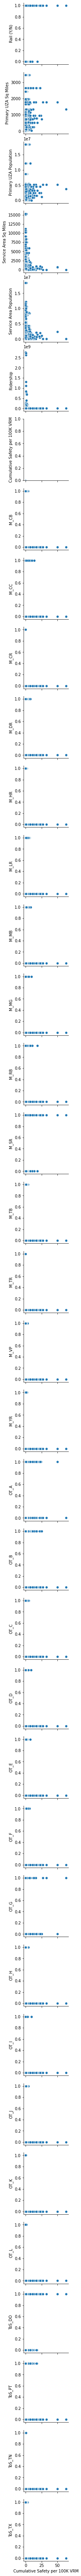

In [48]:

sns.pairplot(
    National_annual,
    x_vars=['Cumulative Safety per 100K VRM'],
    y_vars=National_annual.iloc[:, np.r_[0:6,6:37]],
)


<AxesSubplot:>

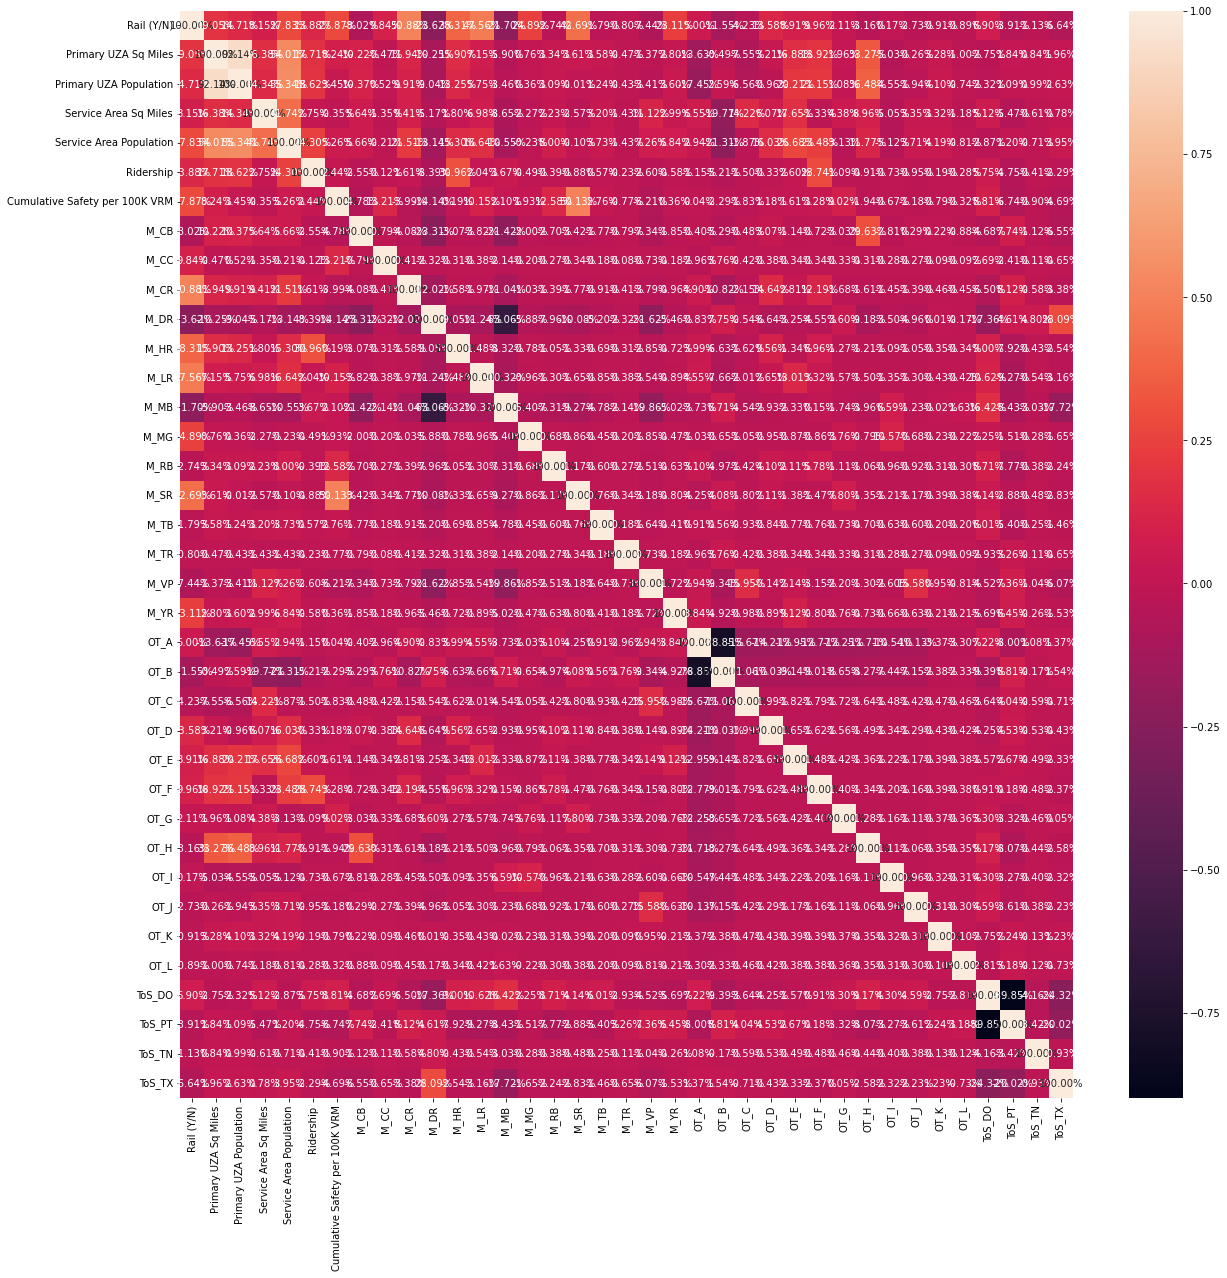

In [49]:
plt.subplots(figsize=(20,20))
sns.heatmap(National_annual.corr(), annot=True, fmt='.2%')

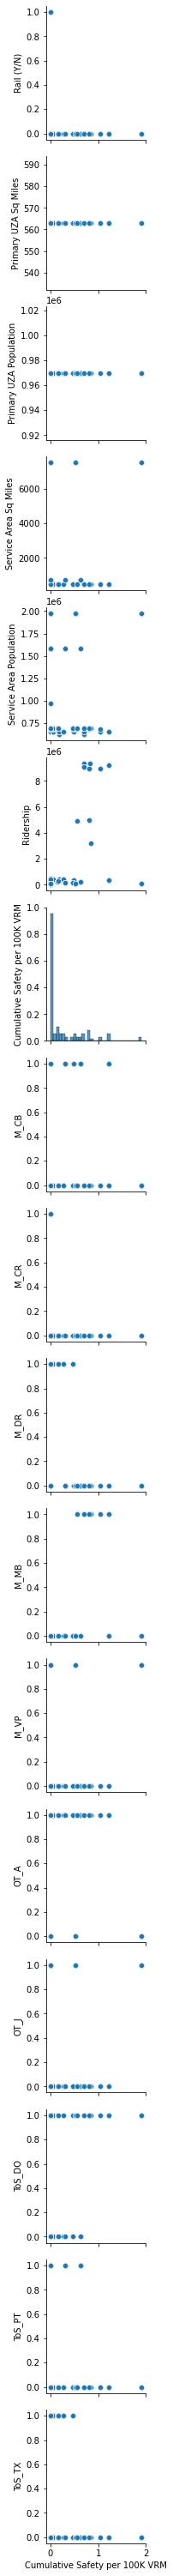

In [50]:
sns.pairplot(
    Nashville_annual,
    x_vars=['Cumulative Safety per 100K VRM'],
    y_vars=Nashville_annual.iloc[:, np.r_[0:6,6:17]],
)

<AxesSubplot:>

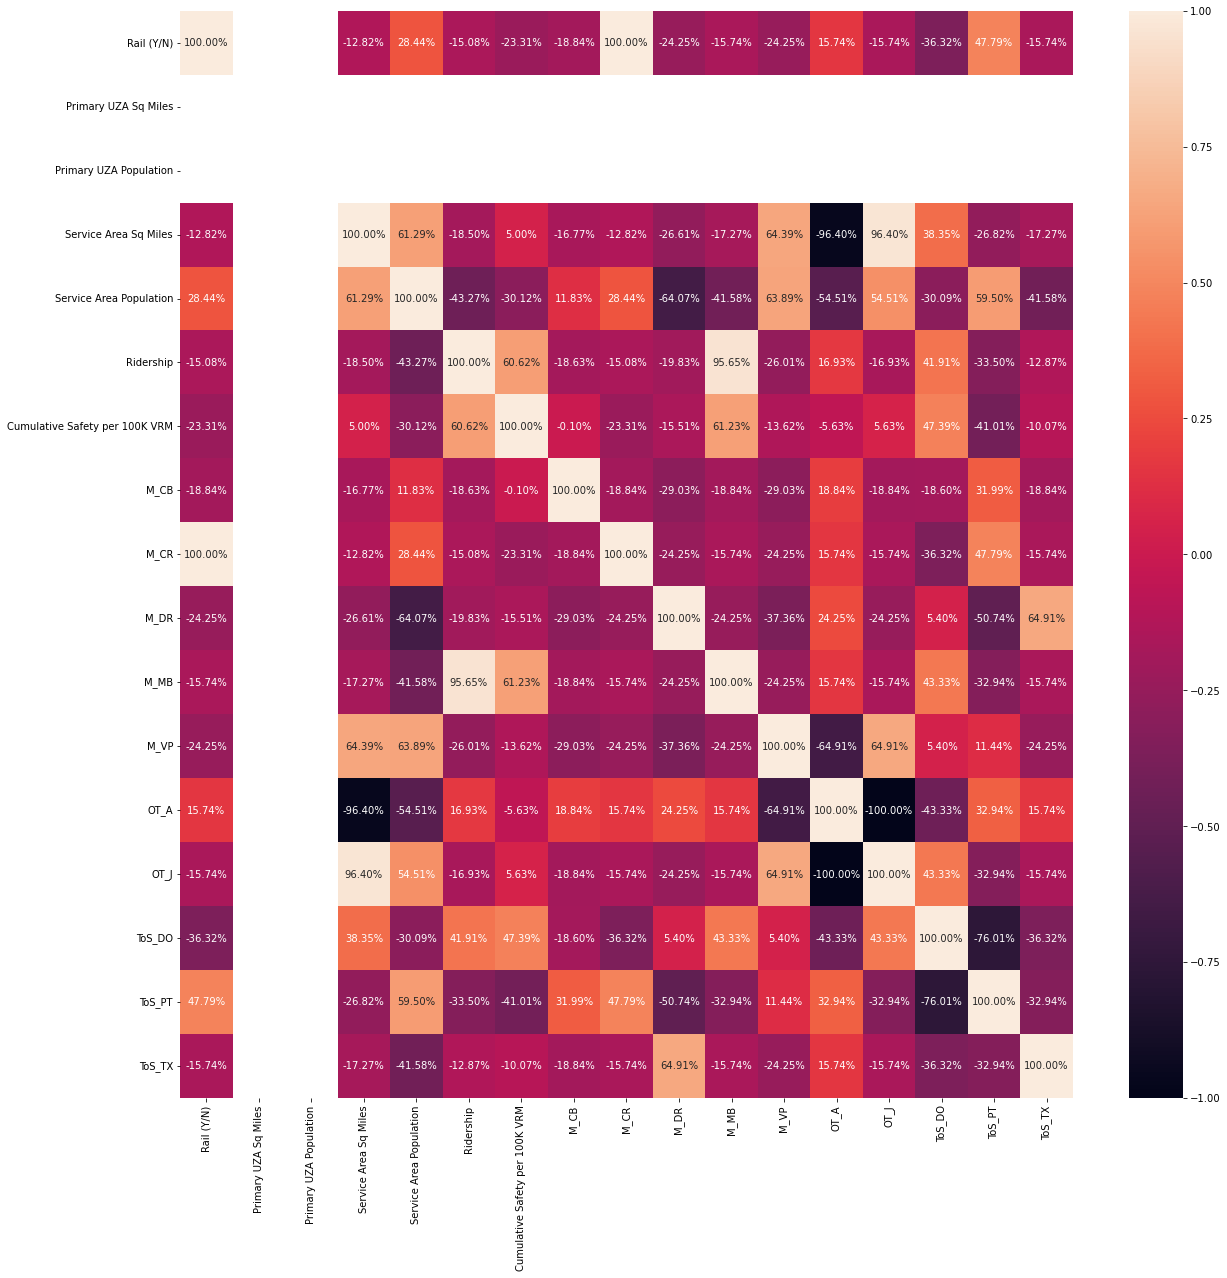

In [51]:
plt.subplots(figsize=(20,20))
sns.heatmap(Nashville_annual.corr(), annot=True, fmt='.2%')

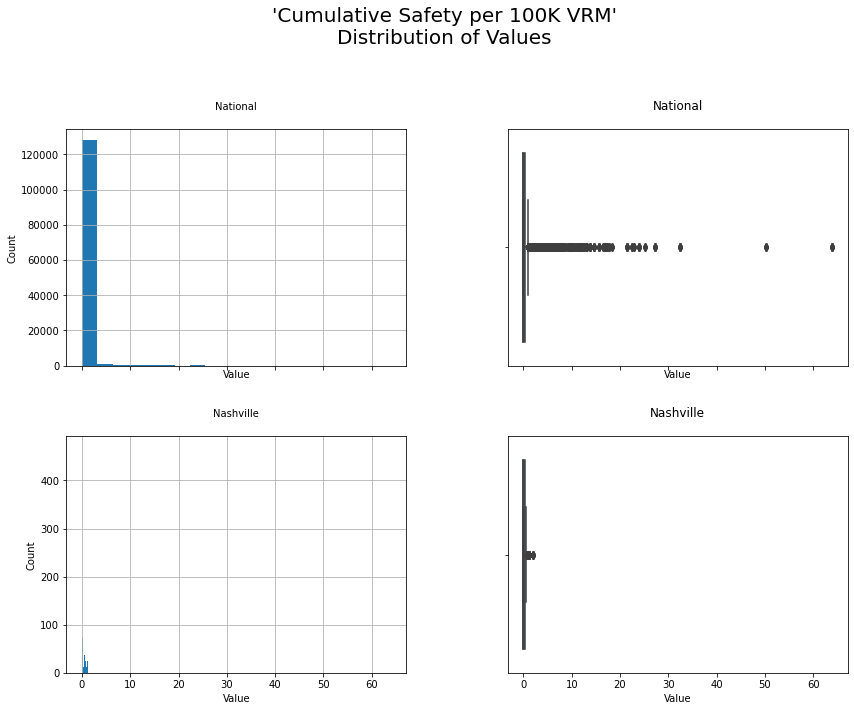

In [52]:
fig, ax =plt.subplots(2,2,figsize=(14,10), sharex=True)
fig.suptitle("'Cumulative Safety per 100K VRM'\nDistribution of Values", fontsize=20, y=1.05)


National_annual.hist('Cumulative Safety per 100K VRM', bins=20, ax=ax[0,0])
ax[0,0].set_title("National", fontsize=10, pad=20)
ax[0,0].set_xlabel("Value")
ax[0,0].set_ylabel("Count")

sns.boxplot(data=National_annual, x='Cumulative Safety per 100K VRM', ax=ax[0,1])
ax[0,1].set_title('National', fontsize=12, pad=20)
ax[0,1].set_xlabel("Value")

Nashville_annual.hist('Cumulative Safety per 100K VRM', bins=20, ax=ax[1,0])
ax[1,0].set_title("Nashville", fontsize=10, pad=20)
ax[1,0].set_xlabel("Value")
ax[1,0].set_ylabel("Count")

sns.boxplot(data=Nashville_annual, x='Cumulative Safety per 100K VRM', ax=ax[1,1])
ax[1,1].set_title('Nashville', fontsize=12, pad=20)
ax[1,1].set_xlabel("Value");

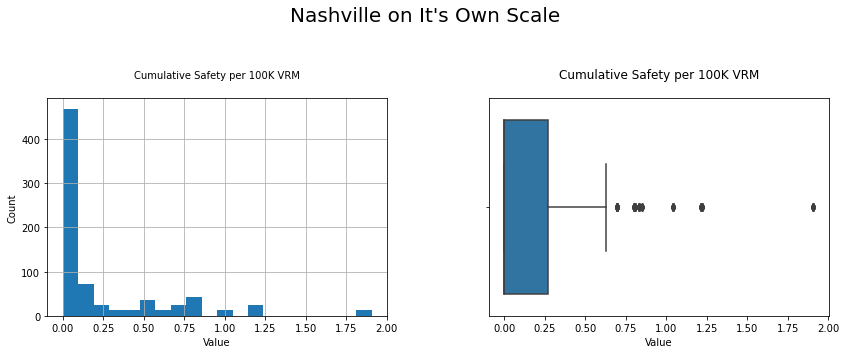

In [53]:
fig, ax =plt.subplots(1,2,figsize=(14,4))
fig.suptitle("Nashville on It's Own Scale", fontsize=20, y=1.2)

Nashville_annual.hist('Cumulative Safety per 100K VRM', bins=20, ax=ax[0])
ax[0].set_title("Cumulative Safety per 100K VRM", fontsize=10, pad=20)
ax[0].set_xlabel("Value")
ax[0].set_ylabel("Count")

sns.boxplot(data=Nashville_annual, x='Cumulative Safety per 100K VRM', ax=ax[1])
ax[1].set_title('Cumulative Safety per 100K VRM', fontsize=12, pad=20)
ax[1].set_xlabel("Value");


## 3.9 Model Selection
<a id= '3.9_Model_Selection'></a>

### 3.9.1 Train/Test Split
<a id= '3.9.1_Train_Test_Split'></a>

In [54]:
#Defining X and y from National_data

X_National = National_annual.drop(['Cumulative Safety per 100K VRM'], axis = 1)
y_National = National_annual['Cumulative Safety per 100K VRM']

In [55]:
# Train/Test split

X_train, X_test, y_train, y_test = train_test_split(X_National, y_National, test_size=0.2, random_state=42)
#X_train.info()

### 3.9.2 Linear Regression
<a id= '3.9.2_Linear_Regression'></a>
I would not expect linear regression to work well because of the number of discrete variables in the dataset, but I will try it anyway.

In [56]:
Model_lr = LinearRegression()

In [57]:
Model_lr.fit(X_train, y_train)

LinearRegression()

In [58]:
y_pred_lr = Model_lr.predict(X_test)

In [59]:
# Evaluating the model with r squared

score_lr = Model_lr.score(X_train, y_train)
score_lr

0.32190615165056

In [60]:
# Finding the Mean Absolute Percent Error 

MAPE_lr = mean_absolute_percentage_error(y_test, y_pred_lr)
MAPE_lr

# This meansure if not effective because it is dividing by zero

536236846221419.9

In [61]:
MSE_lr = mean_squared_error(y_test, y_pred_lr)
MSE_lr

1.231721276451166

### 3.9.3 Random Forest
<a id= '3.9.3_Random_Forest'></a>

In [62]:
Model_rf = RandomForestRegressor()

In [63]:
Model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [64]:
y_pred_rf = Model_rf.predict(X_test)

In [65]:
# Evaluating the model with r squared

score_rf = Model_rf.score(X_train, y_train)
score_rf

0.999735163592241

In [66]:
# Finding the Mean Absolute Percent Error 

MAPE_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
MAPE_rf

# This meansure if not effective because it is dividing by zero

9114172190949.049

In [67]:
MSE_rf = mean_squared_error(y_test, y_pred_rf)
MSE_rf

0.052391031532373206

### 3.9.4 KNN
<a id= '3.9.4_KNN'></a>

In [68]:
Model_knn = KNeighborsRegressor()

In [69]:
Model_knn.fit(X_train, y_train)

KNeighborsRegressor()

In [70]:
y_pred_knn = Model_knn.predict(X_test)

In [71]:
# Evaluating the model with r squared

score_knn = Model_knn.score(X_train, y_train)
score_knn

0.9963473234593364

In [72]:
# Finding the Mean Absolute Percent Error 

MAPE_knn = mean_absolute_percentage_error(y_test, y_pred_knn)
MAPE_knn

# This meansure if not effective because it is dividing by zero

10304785679925.115

In [73]:
MSE_knn = mean_squared_error(y_test, y_pred_knn)
MSE_knn

0.01103569781291559

### 3.9.5 Comparing the Models' Performance
<a id='3.9.5_Comparing_the_Models_Performance'></a>


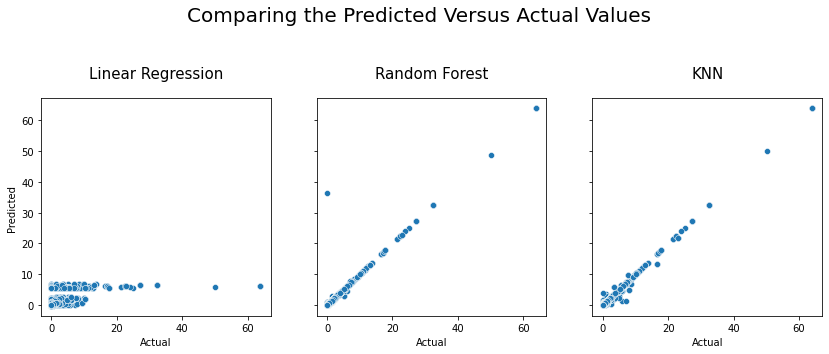

In [74]:
#Comparing the Predicted Versus Actual Values

fig, ax =plt.subplots(1,3,figsize=(14,4), sharey=True, sharex=True)
fig.suptitle("Comparing the Predicted Versus Actual Values", fontsize=20, y=1.2)


sns.scatterplot(x=y_test, y=y_pred_lr, ax=ax[0])
ax[0].set_title("Linear Regression", fontsize=15, pad=20)
ax[0].set_xlabel("Actual")
ax[0].set_ylabel("Predicted")

sns.scatterplot(x=y_test, y=y_pred_rf, ax=ax[1])
ax[1].set_title("Random Forest", fontsize=15, pad=20)
ax[1].set_xlabel("Actual")
ax[1].set_ylabel("Predicted")

sns.scatterplot(x=y_test, y=y_pred_knn, ax=ax[2])
ax[2].set_title("KNN", fontsize=15, pad=20)
ax[2].set_xlabel("Actual")
ax[2].set_ylabel("Predicted");



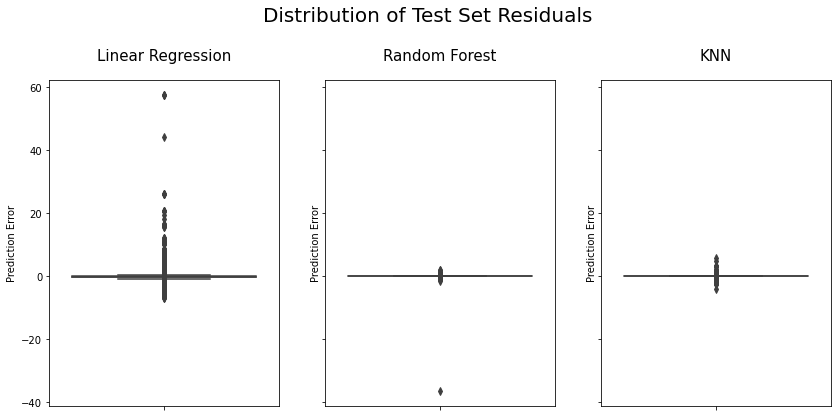

In [75]:
#Comparing the Residuals

diff_lr = (y_test - y_pred_lr)
diff_rf = (y_test - y_pred_rf)
diff_knn = (y_test - y_pred_knn)

fig, ax =plt.subplots(1,3,figsize=(14,6), sharey=True, sharex=True)
fig.suptitle("Distribution of Test Set Residuals", fontsize=20, y=1.05)


sns.boxplot(y=diff_lr, ax=ax[0])
ax[0].set_title("Linear Regression", fontsize=15, pad=20)
ax[0].set_ylabel("Prediction Error")

sns.boxplot(y=diff_rf, ax=ax[1])
ax[1].set_title("Random Forest", fontsize=15, pad=20)
ax[1].set_ylabel("Prediction Error")

sns.boxplot(y=diff_knn, ax=ax[2])
ax[2].set_title("KNN", fontsize=15, pad=20)
ax[2].set_ylabel("Prediction Error");


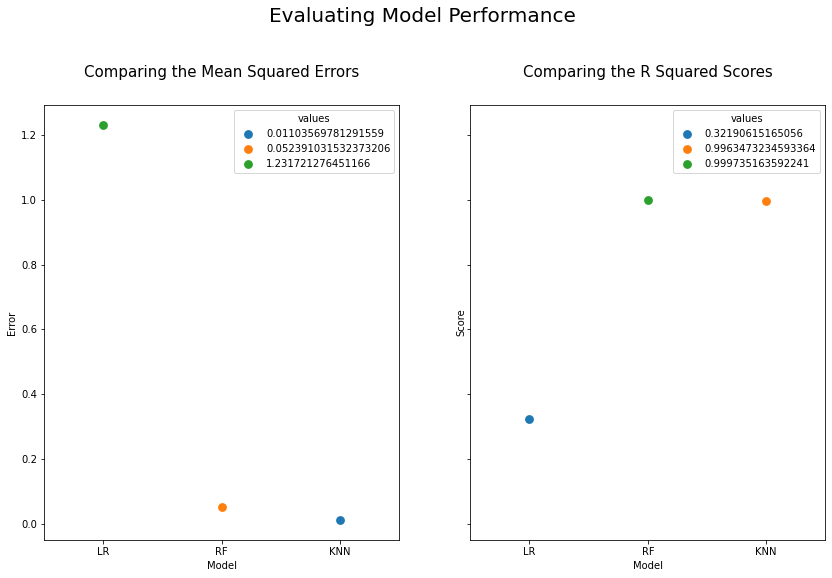

In [76]:
#Comparing the Mean Squared Error

MSEs = pd.Series([MSE_lr, MSE_rf, MSE_knn], name='values')
R2s = pd.Series([score_lr, score_rf, score_knn], name='values')
labels = pd.Series(['LR','RF','KNN'], name='labels')

fig, ax =plt.subplots(1,2,figsize=(14,8), sharey=True, sharex=True)
fig.suptitle("Evaluating Model Performance", fontsize=20, y=1.05)

sns.pointplot(data=pd.concat([MSEs, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[0], hue='values')
ax[0].set_title("Comparing the Mean Squared Errors", fontsize=15, y=1.05)
ax[0].set_xlabel("Model", fontsize=10)
ax[0].set_ylabel("Error", fontsize=10, x=1.05)

sns.pointplot(data=pd.concat([R2s, labels], axis=1), x='labels', y='values', join=False, legend=True, ax=ax[1], hue='values')
ax[1].set_title("Comparing the R Squared Scores", fontsize=15, y=1.05)
ax[1].set_xlabel("Model", fontsize=10)
ax[1].set_ylabel("Score", fontsize=10, x=1.05);

Random Forest and KNN are both good models.  The MSE is slightly better for KNN but the R Squared Score is slightly better for KNN.  Linear Regression is not useful at all.

## 3.10 Save the Data
<a id='3.10_Save_the_Data'></a>

In [77]:
National_data.to_csv("National_data.csv", index=False)
Nashville_data.to_csv("Nashville_data.csv", index=False)
National_annual.to_csv("National_annual.csv", index=False)
Nashville_annual.to_csv("Nashville_annual.csv", index=False)

## 3.11 Summary
<a id='3.11_Summary'></a>

This notebook ends with fully refined dataframes for both the National and Nashville data.  The dependent variable, 'Cumulative Safety per 100K VRM', was clearly defined.  The independent variables were first reduced to avoid overcorrelation and the columns identifying time and location were removed.  After that, the categorical variables were one hot encoded.

Three models were evaluated.  Linear Regression was found not to be useful at all, which was predictable because of the number of discrete variables.  Random Forest and KNN both performed exceedingly well.  